In [1]:
import pandas as pd
import numpy as np
from datetime import date

In [2]:
df = pd.read_csv('EMDAT_Indochina.csv', sep=',', encoding='ISO-8859-1',header=1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 19 columns):
Start date                 388 non-null object
End date                   386 non-null object
Country                    386 non-null object
ISO                        386 non-null object
Location                   363 non-null object
Latitude                   55 non-null float64
Longitude                  57 non-null float64
Magnitude value            147 non-null float64
Magnitude scale            386 non-null object
Disaster type              386 non-null object
Disaster subtype           386 non-null object
Associated disaster        386 non-null object
Associated disaster2       386 non-null object
Total deaths               386 non-null float64
Total affected             386 non-null float64
Total damage ('000 US$)    386 non-null float64
insured_losses             386 non-null float64
Disaster name              107 non-null object
Disaster No.               386 non-null obje

In [4]:
print(df.columns.tolist())

['Start date', 'End date', 'Country', 'ISO', 'Location', 'Latitude', 'Longitude', 'Magnitude value', 'Magnitude scale', 'Disaster type', 'Disaster subtype', 'Associated disaster', 'Associated disaster2', 'Total deaths', 'Total affected', "Total damage ('000 US$)", 'insured_losses', 'Disaster name', 'Disaster No.']


In [5]:
vnDf = df[df['Country'] == 'Viet Nam']

In [6]:
droughtVnDf = vnDf[vnDf['Disaster type'].str.lower() == 'drought']

In [7]:
droughtDf = df[df['Disaster type'].str.lower() == 'drought']

In [8]:
print(droughtDf.shape)

(28, 19)


In [9]:
print(droughtVnDf.shape)

(6, 19)


In [10]:
vnDf = vnDf[['Start date', 'End date', 'Country', 'Location', 'Disaster type']]

In [11]:
floodVnDf = vnDf[vnDf['Disaster type'] == 'Flood']

In [12]:
def str2Date(str, start = True):
    if start:
        day = 1
        month = 1
    else:
        day = 31
        month = 12
    strParser = str.split('/')
    if (strParser[0] != ''):
        day = int(strParser[0])
    if (strParser[1] != ''):
        month = int(strParser[1])
    year = int(strParser[2])
    
    if start == False and day == 31:
        if month == 2:
            day = 28
        elif month in [4, 6, 9, 11]:
            day = 30
    return {'day': day, 'month': month, 'year': year}

### Calculate duration of a disaster by day

In [13]:
def calDurationOfDisaster(transaction):
    t1 = str2Date(transaction['Start date'], True)
    t2 = str2Date(transaction['End date'], False)
    d1 = date(t1['year'], t1['month'], t1['day'])
    d2 = date(t2['year'], t2['month'], t2['day'])
    delta = d2 - d1
    return delta.days

In [14]:
print([calDurationOfDisaster(floodVnDf.iloc[i]) for i in range(20)])

[30, 0, 0, 30, 29, 30, 0, 0, 18, 30, 3, 6, 4, 3, 10, 105, 28, 43, 5, 7]


In [15]:
print([calDurationOfDisaster(droughtVnDf.iloc[i]) for i in range(6)])

[364, 211, 364, 244, 244, 455]


In [16]:
def getMonthOfDisaster(transaction):
    t1 = str2Date(transaction['Start date'], True)
    t2 = str2Date(transaction['End date'], False)
    return {'startMonth': t1['month'], 'endMonth': t2['month'], 'inYear': t1['year'] == t2['year']}

In [17]:
getMonthOfDisaster(floodVnDf.iloc[0])

{'endMonth': 12, 'inYear': True, 'startMonth': 12}

### Statistic disaster by month

In [18]:
def statByMonth(data):
    statByMonth = np.zeros(12)
    for i in range(data.shape[0]):
        transaction = data.iloc[i]
        monthOfDisaster = getMonthOfDisaster(transaction)
        startMonth = monthOfDisaster['startMonth']
        endMonth = monthOfDisaster['endMonth']
        inYear = monthOfDisaster['inYear']
        if inYear == True:
            for i in range(startMonth, endMonth + 1):
                statByMonth[i-1] += 1
        else:
            for i in range(startMonth, 13):
                statByMonth[i-1] += 1
            for i in range(1, endMonth + 1):
                statByMonth[i-1] += 1
    np.delete(statByMonth, 0)
    return statByMonth

In [19]:
statDrought = statByMonth(droughtVnDf)
print(statDrought)

[4. 4. 3. 3. 5. 5. 4. 4. 4. 4. 4. 6.]


In [20]:
statFlood = statByMonth(floodVnDf)
print(statFlood)

[ 1.  0.  0.  1.  2.  3. 13. 14. 23. 32. 20.  8.]


In [21]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x7f34d9c2cb00>,
 <a list of 12 Text xticklabel objects>)

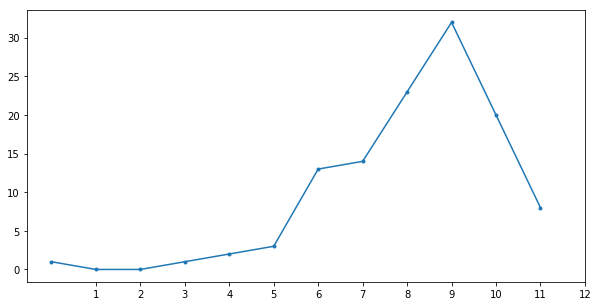

In [22]:
plt.figure(figsize=(10,5))
plt.plot(statFlood, marker='.')
plt.xticks(np.arange(1,13))

In [23]:
def statByMonthAndYear(data, yearStart, yearEnd):
    dataStat = data.copy()
    cnt = 0
    for i in range(data.shape[0]):
        line = data.iloc[i]
        startDate = str2Date(line['Start date'])
        endDate = str2Date(line['End date'])
        _yearStart = startDate['year']
        _yearEnd = endDate['year']
        if (_yearStart >= yearStart and _yearEnd <= yearEnd):
            dataStat.iloc[cnt] = line
            cnt+=1
    dataStat = dataStat.iloc[:cnt]
    return statByMonth(dataStat)

In [24]:
stat1 = statByMonthAndYear(floodVnDf, 2010, 2017)

([<matplotlib.axis.XTick at 0x7f34edb5f518>,
 <a list of 12 Text xticklabel objects>)

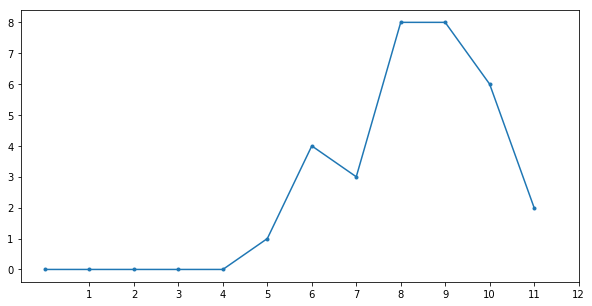

In [25]:
plt.figure(figsize = (10,5))
plt.plot(stat1, marker='.')
plt.xticks(np.arange(1,13))

In [26]:
print(floodVnDf.iloc[0]['Start date'])

/12/1964


([<matplotlib.axis.XTick at 0x7f34d9b4aba8>,
 <a list of 12 Text xticklabel objects>)

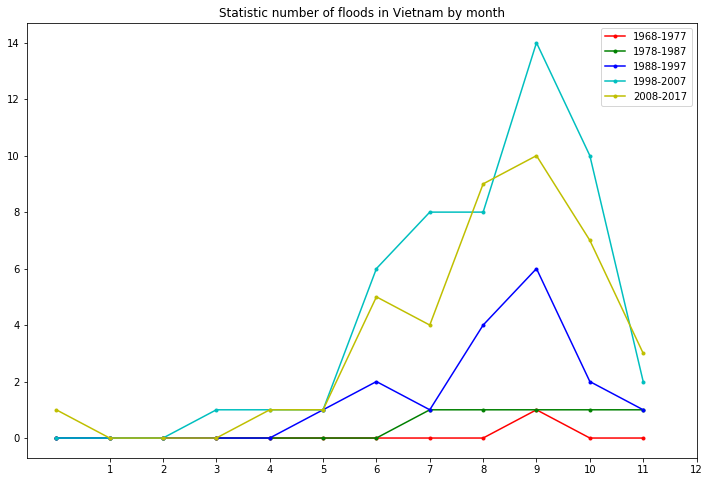

In [27]:
step = 10
yearEnd = np.arange(1967 + step, 2018, step=step)
yearStart = yearEnd - (step - 1)
stat = []
Color = ['r', 'g', 'b', 'c', 'y']
for i in range(yearStart.shape[0]):
    stat.append(statByMonthAndYear(floodVnDf, yearStart[i], yearEnd[i]))

plt.figure(figsize=(12,8))
for i, s in enumerate(stat):
    plt.plot(s, color = Color[i], label = str(yearStart[i]) + '-' + str(yearEnd[i]), marker='.')

plt.title('Statistic number of floods in Vietnam by month')
plt.legend()
plt.xticks(np.arange(1,13))

In [28]:
floodDuration = [calDurationOfDisaster(floodVnDf.iloc[i]) for i in range(floodVnDf.shape[0])]

(array([66., 12.,  1.,  1.,  0.,  1.,  2.,  1.,  0.,  1.]),
 array([  0. ,  15.2,  30.4,  45.6,  60.8,  76. ,  91.2, 106.4, 121.6,
        136.8, 152. ]),
 <a list of 10 Patch objects>)

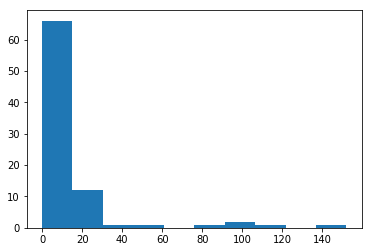

In [29]:
plt.hist(floodDuration)

In [30]:
def histogram(data, bins = 10):
    max = data[0]
    for d in data:
        if d > max:
            max = d
    binSize = max/bins
    a = np.arange(1, max + 2, step = int(binSize))
    a[-1] = max+1
    a[0] = 0
    cnt = np.zeros(a.shape[0] - 1)
    for d in data:
        for i in range(a.shape[0] - 1):
            if d >= a[i] and d < a[i+1]:
                cnt[i] += 1
                break
    return cnt

In [31]:
floodHist = histogram(floodDuration, 10)

In [32]:
print(floodHist)

[66. 12.  1.  1.  0.  1.  2.  0.  1.  1.]


([<matplotlib.axis.XTick at 0x7f34d9a718d0>,
 <a list of 10 Text xticklabel objects>)

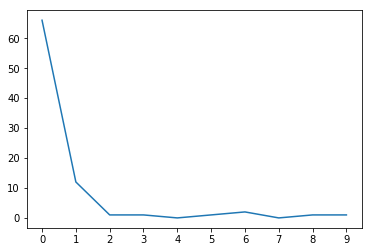

In [33]:
plt.plot(floodHist)
plt.xticks(np.arange(0,10,step=1))

In [34]:
print(vnDf.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 190 to 385
Data columns (total 5 columns):
Start date       196 non-null object
End date         196 non-null object
Country          196 non-null object
Location         190 non-null object
Disaster type    196 non-null object
dtypes: object(5)
memory usage: 9.2+ KB
None


# Deal with location axis

In [35]:
import geopandas as gpd
shapefilePath = '/home/lamductan/Hydroviet/disaster-db/vnShapefile/VNM_adm1'
vnShapefile = gpd.read_file(shapefilePath + '.shp')

In [36]:
a = vnShapefile[vnShapefile['CCA_1'] == '0'].index

In [37]:
vnShapefile = vnShapefile.drop(a)
vnShapefile.reset_index(drop=True)

,ID_0,ISO,NAME_0,ID_1,NAME_1,HASC_1,CCN_1,CCA_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,250,VNM,Vietnam,1,Đà Nẵng,VN.DA,0,501,Thành phố trực thuộc tỉnh,City|Municipality|Thanh Pho,None,Da Nang City|Da Nang,(POLYGON ((108.2249908447266 16.10028076171881...
1,250,VNM,Vietnam,2,Đồng Nai,VN.DN,0,713,Tỉnh,Province,None,Dong Nai,(POLYGON ((106.9713897705081 10.60722160339355...
2,250,VNM,Vietnam,3,Đồng Tháp,VN.DT,0,803,Tỉnh,Province,None,Dong Thap,"POLYGON ((105.432846069336 10.97352027893066, ..."
3,250,VNM,Vietnam,4,Đăk Nông,VN.DO,0,606,Tỉnh,Province,None,Dac Nong,"POLYGON ((107.8588180541993 12.80136299133301,..."
4,250,VNM,Vietnam,5,Đắk Lắk,VN.DC,0,605,Tỉnh,Province,None,Dak Lak|Dac Lac,"POLYGON ((108.1227264404299 13.41130828857428,..."
5,250,VNM,Vietnam,6,Điện Biên,VN.DB,0,302,Tỉnh,Province,None,Dien Bien,"POLYGON ((102.3428497314454 22.52911376953119,..."
6,250,VNM,Vietnam,7,An Giang,VN.AG,0,805,Tỉnh,Province,None,An Giang,"POLYGON ((105.116882324219 10.95687103271484, ..."
7,250,VNM,Vietnam,8,Bà Rịa - Vũng Tàu,VN.BV,0,717,Tỉnh,Province,None,Ba Ria - VTau|Ba Ria-Vung Tau,(POLYGON ((106.1453323364259 8.606149673461914...
8,250,VNM,Vietnam,9,Bình Định,VN.BD,0,507,Tỉnh,Province,None,Binh Dinh,(POLYGON ((109.3632507324218 13.59976959228521...
9,250,VNM,Vietnam,10,Bình Dương,VN.BI,0,711,Tỉnh,Province,None,Binh Duong,"POLYGON ((106.4463500976564 11.49944972991955,..."


In [38]:
list_province = vnShapefile['VARNAME_1'].tolist()
print(list_province[41])

Ninh Binh


In [39]:
values = np.zeros(len(list_province)).astype(int)

##### Normalize string: remove spaces, '-', '?'; translate unicode character to ascii character and return in lowercase

In [40]:
def normalizeStr(str):
    from unidecode import unidecode
    str  = str.strip('\r\n')
    norm_s = str.replace(' ', '')
    norm_s = norm_s.replace('-', '')
    norm_s = norm_s.replace('?', '')
    if norm_s.find('(') >= 0: norm_s = norm_s[:norm_s.find('(')]
    norm_s = unidecode(norm_s)
    return norm_s.lower()

In [41]:
norm_list_province = []
for province in list_province:
    norm_list_province.append(normalizeStr(province))

#### Statistic disaster by province

In [42]:
def statByProvince(data, yearStart, yearEnd):
    cnt = dict(zip(norm_list_province, np.zeros(len(norm_list_province)).astype(int)))
    for i in range(data.shape[0]):
        line = data.iloc[i]
        startDate = str2Date(line['Start date'])
        year = startDate['year']
        if (line['Country'] == 'Viet Nam' and year >= yearStart and year <= yearEnd):
            s = line['Location'].replace(';', ',')
            locations = s.split(',')
            for i in range(len(locations)):
                locations[i] = normalizeStr(locations[i])
            for location in locations:
                for key, value in cnt.items():
                    if location in key or key in location:
                        cnt[key] += 1
    return cnt
                
statFlood = statByProvince(floodVnDf, 1980, 2017)
print()
print(statFlood)


{'danangcity|danang': 9, 'dongnai': 5, 'dongthap': 17, 'dacnong': 0, 'daklak|daclac': 9, 'dienbien': 6, 'angiang': 17, 'bariavtau|bariavungtau': 2, 'binhdinh': 21, 'binhduong': 2, 'binhphuoc': 2, 'binhthuan': 9, 'baclieu': 2, 'bacgiang': 2, 'backan|baccan': 8, 'bacninh': 2, 'bentre': 3, 'camau': 2, 'caobang': 7, 'cantho': 9, 'gialai': 6, 'hagiang': 10, 'hanoicity|hanoi': 3, 'hanam': 5, 'hatinh': 18, 'hochiminhcity|hochiminh': 2, 'hoabinh': 5, 'hungyen': 2, 'haiduong': 2, 'haiphongcity|haiphong': 2, 'haugiang': 3, 'khanhhoa': 13, 'kiengiang': 11, 'kontum': 6, 'laocai': 8, 'lamdong': 8, 'laichau': 10, 'langson': 3, 'longan': 11, 'namdinh': 3, 'nghean': 17, 'ninhbinh': 4, 'ninhthuan': 9, 'phutho': 5, 'phuyen': 15, 'quangbinh': 17, 'quangnam': 25, 'quangngai': 24, 'quangninh': 4, 'quangtri': 26, 'soctrang': 3, 'sonla': 9, 'tayninh': 2, 'thaibinh': 3, 'thainguyen': 6, 'thuathienhue': 22, 'thanhhoa': 10, 'tiengiang': 8, 'travinh': 3, 'tuyenquang': 5, 'vinhlong': 8, 'vinhphuc': 4, 'yenbai': 

<Container object of 63 artists>

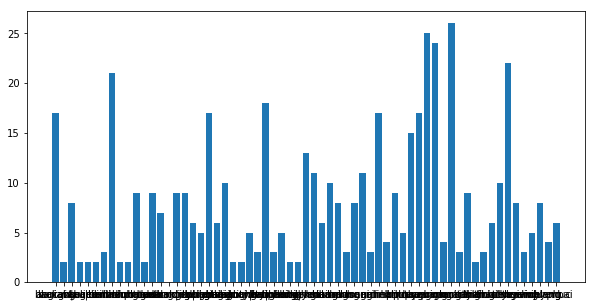

In [43]:
plt.figure(figsize=(10,5))
plt.bar(statFlood.keys(), statFlood.values())

## To be continued: Visualize on Vietnam's map

In [44]:
def geo_heatmap(shapes, scores, ax=None, order=None, overlay=False, colormap='coolwarm', minv=0.0, maxv=1.0):

    from sklearn.preprocessing import minmax_scale
    from matplotlib.collections import PatchCollection
    from shapely.geometry import Polygon, MultiPolygon, shape
    from descartes import PolygonPatch
    from matplotlib import pyplot as plt
    from matplotlib import ticker

    cm = plt.get_cmap(colormap)
    #scale = minmax_scale(scores)
    scale = scores
    minv = scores.min()
    maxv = scores.max()

    if ax is None:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111)

    mp = MultiPolygon(shapes)

    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    patches = []
    for yield_diff, p in zip(scale, shapes):
        color = cm(yield_diff)
        if overlay:
            patches.append(PolygonPatch(p, fc='none', ec='#555555', zorder=1))
        else:
            patches.append(PolygonPatch(p, fc=color, ec='#555555', zorder=1))
    p = PatchCollection(patches, match_original=True, cmap=colormap)
    ax.add_collection(p)
    ax.axis('off')
    p.set_array(np.array(scale))
    if minv is None or maxv is None:
        minv = np.ma.min(scores)
        maxv = np.ma.max(scores)
    p.set_clim([minv, maxv])
    cb = plt.colorbar(p, shrink=0.5, ax=ax)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    
    #plt.show()
    
    return ax

In [50]:
def statAndVisualizeInDecade(data, yearStart, yearEnd, shapefile):
    listYearStart = np.arange(yearStart, yearEnd, 10)
    listYearEnd = listYearStart + 9
    listYearEnd[-1] = yearEnd
    
    from shapely.geometry import Polygon, MultiPolygon, shape
    shapes = [shape(p) for p in shapefile['geometry']]
    
    nDecades = len(listYearStart)
    country = data.iloc[0]['Country']
    
    from matplotlib import pyplot as plt
    import math
    fig, axes = plt.subplots(math.ceil(nDecades/2), 2, figsize=(15,15))
    fig.suptitle('Number of floods of {0} \'s provinces in {1} - {2} by decade'.format(country, yearStart, yearEnd), fontsize=20, fontweight='bold')

    for i in range(math.ceil(nDecades/2)):
        for j in range(2):
            index = i*2+j
            yStart = listYearStart[index]
            yEnd = listYearEnd[index]
            stat = statByProvince(data, yStart, yEnd)
            scores = np.array(list(stat.values()), np.int)
            geo_heatmap(shapes, scores, ax=axes[i][j])
            axes[i][j].set_title('{0} - {1}'.format(yStart, yEnd))
            
    fig.savefig('Flood heatmap')
    
    

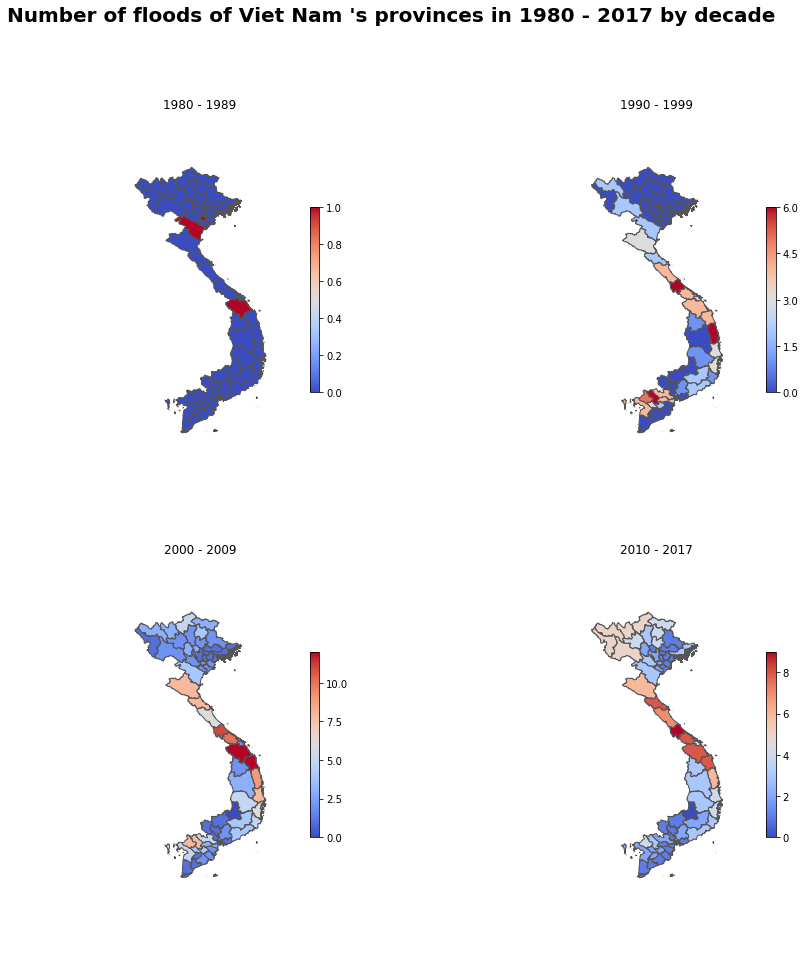

In [51]:
statAndVisualizeInDecade(floodVnDf, 1980, 2017, vnShapefile)